#COMP0036: Beat the Bookie
Importing and initial exploration of data<br>


# 1. Introduction

# 1. Data Import
## 1.1 Given Data
The data files provided on moodle are uploaded to a Google drive. The location of the files on drive should be modified in line 3. 
In this section we also import the requiered dependencies. 

In [3]:
from google.colab import drive

# mount google drive
drive.mount('/content/drive')

# change directory to the desired one
%cd '/content/drive/MyDrive/ML_Bosses_shared/Data_Files'

# list items in directory
print("\n\nCurrent directory:\n")
!ls

Mounted at /content/drive
/content/drive/MyDrive/ML_Bosses_shared/Data_Files


Current directory:

ELO.csv		   epl_marketval.gsheet  epl-training.csv
epl_marketval.csv  epl-test.csv		 sample-submission.csv


In [4]:
import os
import re
import sklearn
import numpy as np 
from numpy import NaN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df_training = pd.read_csv('epl-training.csv')
df_training

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,23/05/2021,Liverpool,Crystal Palace,2,0,H,1,0,H,C Pawson,19,5,5,4,10,8,14,1,2,2,0,0
4936,23/05/2021,Man City,Everton,5,0,H,2,0,H,M Oliver,21,8,11,3,8,10,7,5,2,2,0,0
4937,23/05/2021,Sheffield United,Burnley,1,0,H,1,0,H,K Friend,12,10,3,3,11,1,8,9,3,1,0,0
4938,23/05/2021,West Ham,Southampton,3,0,H,2,0,H,M Atkinson,14,17,7,5,5,9,2,3,0,3,0,0


In [6]:
#dividing matches into seasons (of 380 games)
df_training.insert(0, 'Season', NaN)
df_training['Season']=np.divmod(np.arange(len(df_training)),380)[0]+2008

In [7]:
df_training

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,2008,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,2008,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,2008,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,2008,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,2008,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2020,23/05/2021,Liverpool,Crystal Palace,2,0,H,1,0,H,C Pawson,19,5,5,4,10,8,14,1,2,2,0,0
4936,2020,23/05/2021,Man City,Everton,5,0,H,2,0,H,M Oliver,21,8,11,3,8,10,7,5,2,2,0,0
4937,2020,23/05/2021,Sheffield United,Burnley,1,0,H,1,0,H,K Friend,12,10,3,3,11,1,8,9,3,1,0,0
4938,2020,23/05/2021,West Ham,Southampton,3,0,H,2,0,H,M Atkinson,14,17,7,5,5,9,2,3,0,3,0,0


## 1.2 Other Data Sources
In this section we obtain data for Market Value and age  of the players  from www.transfermarkt.com. The final result is stored in epl_marketval.csv on the Google Drive. 

In [8]:
import requests
from bs4 import BeautifulSoup

In [9]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

Clubs = []
Values = []
Ages = []

for seasons in [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]:

      page = "https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id={}".format(seasons)
      pageTree = requests.get(page, headers=headers)
      pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

      Club = pageSoup.find_all("td", {"class": "rechts hide-for-small hide-for-pad"})
      #Value = pageSoup.find_all("td", {"class": "rechts hide-for-small hide-for-pad"})  
      #soup.find('a', {title : 'export' })['href']
      #Club

      for i in range(0, len(Club)):
        try:
          Clubs.append(str(Club[i]).split('title="',1)[1].split('">€',1)[0])
        except IndexError:
          pass

      #for i in range(0, len(Value)):
      # obtaining market vaule for each team for each season in euros
        if i%2 == 1:
          try:
            Values.append(str(Club[i]).split('">€',1)[1].split('m</a>',1)[0])
          except IndexError:
            pass

      Age = pageSoup.find_all("td", {"class": "zentriert hide-for-small hide-for-pad"})
      for i in range(1, len(Age)):
        try:
          Ages.append(str(Age[i]).split('hide-for-pad">',1)[1].split('</td>',1)[0])
        except IndexError:
          pass

In [10]:
FinalValues = []
for a in list(range(len(Values))):
  if 'b' in Values[a]:
    FinalValues.append(float(str(Values[a].split('b')[0]))*1000000000)
  else:
    FinalValues.append(float(Values[a])*1000000)

In [11]:
df_market_val = pd.DataFrame({"Team":Clubs,
                              "Market Value":FinalValues,
                              "Avg_Age":Ages})
df_market_val.insert(0, 'Season', NaN)
df_market_val['Season']=np.divmod(np.arange(len(df_market_val)),20)[0]+2008

In [12]:
# replacing team names to match original training set
df_market_val = df_market_val.replace({' FC': '', ' AFC':'','AFC ':'', 'Bromwich Albion':'Brom',' &amp; Hove Albion': '',' Town': '', 'Wolverhampton':'Wolves', ' Wanderers':'', ' Athletic': '','Queens Park Rangers':'QPR', ' Hotspur':'', ' Rovers':''}, regex=True)
df_market_val = df_market_val.replace({'Manchester United':'Man U' ,' United':'', 'Manchester City':'Man C' ,' City':''}, regex=True)
df_market_val = df_market_val.replace({'Man U':'Man United','Sheffield':'Sheffield United' , 'Man C':'Man City'}, regex=True)

In [14]:
# df_market_val.head()
df_market_val.to_csv('epl_marketval.csv', index=False)

In [16]:
df_market_val = pd.read_csv('epl_marketval.csv')
df_market_val.head(10)

,Season,Team,Market Value,Avg_Age
0,2008,Chelsea,404200000.0,25.6
1,2008,Man United,356100000.0,24.3
2,2008,Liverpool,254730000.0,23.9
3,2008,Arsenal,250850000.0,21.3
4,2008,Tottenham,212600000.0,22.5
5,2008,Man City,205300000.0,24.0
6,2008,Everton,162550000.0,24.4
7,2008,Newcastle,134950000.0,24.8
8,2008,Portsmouth,131500000.0,26.8
9,2008,Aston Villa,111800000.0,25.4


Similar method used here to match basketball ratings to teams for each season.
<br>
https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021/notebook#Feature-Engineering


## 1.3 Merge Data Sets
All data sets are merged in this section in the df_trainingmod variable and stored on the drive.

In [ ]:
#### merging market value data for each team at each season with original training data
df_trainingmod = pd.merge(
    df_training,
    df_market_val,
    how='left',
    left_on=['Season', 'HomeTeam'],
    right_on=['Season', 'Team']
).drop('Team', axis=1).rename(columns={'Market Value': 'HMarketVal', 'Avg_Age':'HAvg_Age'})

df_trainingmod = pd.merge(
    df_trainingmod,
    df_market_val,
    how='left',
    left_on=['Season', 'AwayTeam'],
    right_on=['Season', 'Team']
).drop('Team', axis=1).rename(columns={'Market Value': 'AMarketVal', 'Avg_Age':'AAvg_Age'})

In [ ]:
df_trainingmod


,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HMarketVal,HAvg_Age,AMarketVal,AAvg_Age
0,2008,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,2.508500e+08,21.3,64050000.0,24.6
1,2008,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,8.470000e+07,25.2,49700000.0,26.6
2,2008,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,1.625500e+08,24.4,86750000.0,26.4
3,2008,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,3.863000e+07,27.3,73100000.0,25.3
4,2008,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,7.365000e+07,22.3,212600000.0,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2020,23/05/2021,Liverpool,Crystal Palace,2,0,H,1,0,H,C Pawson,19,5,5,4,10,8,14,1,2,2,0,0,1.090000e+09,23.4,236350000.0,26.7
4936,2020,23/05/2021,Man City,Everton,5,0,H,2,0,H,M Oliver,21,8,11,3,8,10,7,5,2,2,0,0,1.050000e+09,23.9,522450000.0,23.7
4937,2020,23/05/2021,Sheffield United,Burnley,1,0,H,1,0,H,K Friend,12,10,3,3,11,1,8,9,3,1,0,0,1.437500e+08,23.9,150300000.0,25.6
4938,2020,23/05/2021,West Ham,Southampton,3,0,H,2,0,H,M Atkinson,14,17,7,5,5,9,2,3,0,3,0,0,3.180500e+08,25.6,226400000.0,23.6


In [ ]:
df_trainingmod.to_csv('epl_trainingmod.csv')

Data we could add: - however these values are made available at the end of a season so may need to base on previous seasons results (or use values for 21/22 obtained so far)<br>
Percentage possesion:
https://en.as.com/resultados/futbol/inglaterra/2020_2021/ranking/equipos/porcentaje-de-posesion/
Scored/Conceeded first as a percentage of matches:
https://www.soccerstats.com/table.asp?league=england_2020&tid=sc
Elo Calc: https://www.kaggle.com/paultimothymooney/predict-ncaa-basketball-2017-491782

<br><br>

Helpful ref for basic model: https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better/notebook#Modeling <br>
Elo calc method: https://www.kaggle.com/paultimothymooney/predict-ncaa-basketball-2017-491782 <br>
Could consider effect of home vs away on each specific team: https://medium.com/geekculture/building-a-simple-football-prediction-model-using-machine-learning-f061e607bec5

# 3. Data Transformation & Exploration

#Feature Engineering
As no match specific info is available for the test set we should transform the match info into prior estimations. e.g. cumulative/rolling average or sum for each team (maybe for each season) <br>
Method for calculating moving averages when team can appear in either home or 
away columns uses stack to create multi level index. The shift method is included to exclude the current match from the average - however this shifts the average for the most recent matches to the top of the dataset (as this is only a small proportion the effect should be minimal). The values at the top of the dataset can be used as predictors for the test set.

In [ ]:
#goal moving average of previous 38 matches (as this is how many a team plays in one season) - using shift() to exclude current match but this method shift most recent match to beginning of dataframe
df_trainingmod = df_trainingmod.join((df_trainingmod[['FTHG','FTAG']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
   .rolling(38).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('38_Avg_')))

#foul moving average
df_trainingmod = df_trainingmod.join(df_trainingmod[['HF','AF']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
   .rolling(38).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('38_Avg_'))

#shots moving average 
df_trainingmod = df_trainingmod.join(df_trainingmod[['HS','AS']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
   .rolling(38).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('38_Avg_'))

#red card moving average 
df_trainingmod = df_trainingmod.join(df_trainingmod[['HR','AR']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
   .rolling(38).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('38_Avg_'))

#yellow card moving average
df_trainingmod = df_trainingmod.join(df_trainingmod[['HY','AY']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
   .rolling(38).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('38_Avg_'))


#Add rolling/cumulative average w/d/l or last seasons total
#add ELO/ some kind of rating system

In [ ]:
#should convert these to some kind of average if using - dependant on current game 

# #HGSR -> Home goals to shots ratio
# df_trainingmod['HGSR'] = df_trainingmod['FTHG'] / df_trainingmod['HS']
# #AGSR -> Away goals to shots ratio
# df_trainingmod['AGSR'] = df_trainingmod['FTAG'] / df_trainingmod['AS']

# #HSTR -> Home shots on target to shots on goal ratio
# df_trainingmod['HSTR'] = df_trainingmod['HST'] / df_trainingmod['HS']
# #ASTR -> Away shots on target to shots on goal ratio
# df_trainingmod['ASTR'] = df_trainingmod['AST'] / df_trainingmod['AS']

# #goal difference (home team - away team)
# df_trainingmod['FTG_Diff'] = df_trainingmod['FTHG'] - df_trainingmod['FTAG']

#Market value difference (Home - Away) rather than using both features individually
df_trainingmod['Mar_Val_Diff'] = df_trainingmod['HMarketVal'] - df_trainingmod['AMarketVal']

In [ ]:
#filling missing values with column average - could try median, mode or 0

df_trainingmod['38_Avg_FTHG'].fillna(df_trainingmod['38_Avg_FTHG'].mean(), inplace = True)
df_trainingmod['38_Avg_FTAG'].fillna(df_trainingmod['38_Avg_FTAG'].mean(), inplace = True)

df_trainingmod['38_Avg_HF'].fillna(df_trainingmod['38_Avg_HF'].mean(), inplace = True)
df_trainingmod['38_Avg_AF'].fillna(df_trainingmod['38_Avg_AF'].mean(), inplace = True)

df_trainingmod['38_Avg_HS'].fillna(df_trainingmod['38_Avg_HS'].mean(), inplace = True)
df_trainingmod['38_Avg_AS'].fillna(df_trainingmod['38_Avg_AS'].mean(), inplace = True)

df_trainingmod['38_Avg_HR'].fillna(df_trainingmod['38_Avg_HR'].mean(), inplace = True)
df_trainingmod['38_Avg_AR'].fillna(df_trainingmod['38_Avg_AR'].mean(), inplace = True)

df_trainingmod['38_Avg_HY'].fillna(df_trainingmod['38_Avg_HY'].mean(), inplace = True)
df_trainingmod['38_Avg_AY'].fillna(df_trainingmod['38_Avg_AY'].mean(), inplace = True)

In [ ]:
#encoding HTR and FTR
df_trainingmod['HTR'] = df_trainingmod['HTR'].replace({'H':0, 'D':1, 'A':2}, regex=True)
df_trainingmod['FTR'] = df_trainingmod['FTR'].replace({'H':0, 'D':1, 'A':2}, regex=True)

In [ ]:
#converting age info from transfermarkt to float
df_trainingmod['HAvg_Age'] = pd.to_numeric(df_trainingmod['HAvg_Age'], downcast="float")
df_trainingmod['AAvg_Age'] = pd.to_numeric(df_trainingmod['AAvg_Age'], downcast="float")

In [ ]:
##Tracking wins/draws for home and away seperately for ease of use later on (can drop these columns from dataset) - as FTR just specifies home/away not the specific team
df_trainingmod['HomeWin']= np.where(df_trainingmod.FTR == 0, 3, 0)
df_trainingmod['HomeWin']= np.where(df_trainingmod.FTR == 1, 1, df_trainingmod['HomeWin']*1)

df_trainingmod['AwayWin']= np.where(df_trainingmod.FTR == 2, 3, 0)
df_trainingmod['AwayWin']= np.where(df_trainingmod.FTR == 1, 1, df_trainingmod['AwayWin']*1)

df_trainingmod['HomeWin']= np.where(df_trainingmod.FTR == 0, 1, 0)
df_trainingmod['HomeDraw']= np.where(df_trainingmod.FTR == 1, 1, 0)
df_trainingmod['HomeLoss']= np.where(df_trainingmod.FTR == 2, 1, 0)

df_trainingmod['AwayWin']= np.where(df_trainingmod.FTR == 2, 1, 0)
df_trainingmod['AwayDraw']= np.where(df_trainingmod.FTR == 1, 1, 0)
df_trainingmod['AwayLoss']= np.where(df_trainingmod.FTR == 0, 1, 0)

In [ ]:
#can include rolling average of wins or draws but found they made logisticregression less accurate
#tested a few values e.g. 5,10,25,50

#rolling average wins 
#df_trainingmod = df_trainingmod.join(df_trainingmod[['HomeWin','AwayWin']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
#   .rolling(50).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('50_Avg_'))

#rolling average draws
df_trainingmod = df_trainingmod.join(df_trainingmod[['HomeDraw','AwayDraw']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
  .rolling(50).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('50_Avg_'))

#filling empty cells with column average
df_trainingmod['50_Avg_HomeDraw'].fillna(df_trainingmod['50_Avg_HomeDraw'].mean(), inplace = True)
df_trainingmod['50_Avg_AwayDraw'].fillna(df_trainingmod['50_Avg_AwayDraw'].mean(), inplace = True)

#rolling average losses
#df_trainingmod = df_trainingmod.join(df_trainingmod[['HomeLoss','AwayLoss']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
#   .rolling(50).mean().shift().reset_index(level=0, drop=True).unstack().add_prefix('50_Avg_'))


Attack/Defence Strength

In [ ]:
#global stats
Global = df_training[['FTHG','FTAG']].mean()
GlobalHome = Global['FTHG']
GlobalAway = Global['FTAG']

#Home stats (Attack = avg scored goals / global avg scored goals, Def = avg allowed goals / global avg allowed goals)
HomeAvg = df_training.groupby(['HomeTeam']).mean()
HomeAttAvg = HomeAvg['FTHG']
HomeDefAvg = HomeAvg['FTAG']
HomeAtt = HomeAttAvg / GlobalHome
HomeDef = HomeAttAvg / GlobalAway

#Away stats (Attack = avg scored goals / global avg scored goals, Def = avg allowed goals / global avg allowed goals)
AwayAvg = df_training.groupby(['AwayTeam']).mean()
AwayAttAvg = AwayAvg['FTHG']
AwayDefAvg = AwayAvg['FTAG']
AwayAtt = AwayAttAvg / GlobalAway
AwayDef = AwayDefAvg / GlobalHome

#creating joint table
df_power = pd.DataFrame([HomeAtt,HomeDef,AwayAtt,AwayDef])
stats = df_power.T #transposing df
stats.reset_index(inplace=True)

stats.set_axis(["Team","HAP", "HDP", "AAP", "ADP"], axis=1, inplace=True) #renaming columns (Home/Away Attack/Dafense Power)

stats

,Team,HAP,HDP,AAP,ADP
0,Arsenal,1.320158,1.709314,1.139543,1.072464
1,Aston Villa,0.787879,1.020130,1.419311,0.688538
2,Birmingham,0.650856,0.842716,1.552371,0.633729
3,Blackburn,0.839262,1.086660,1.796315,0.659420
4,Blackpool,1.027668,1.330604,1.818492,0.856390
5,Bolton,0.890646,1.153190,1.530194,0.659420
6,Bournemouth,0.931752,1.206414,1.614466,0.719368
7,Brighton,0.727931,0.942511,1.241897,0.539526
8,Burnley,0.699793,0.906078,1.470000,0.601920
9,Cardiff,0.702240,0.909246,1.552371,0.428195


In [ ]:
df_trainingmod = pd.merge(
    df_trainingmod,
    stats[['Team','HAP','HDP']],
    how='left',
    left_on=['HomeTeam'],
    right_on=['Team']
).drop('Team', axis=1)


df_trainingmod = pd.merge(
    df_trainingmod,
    stats[['Team','AAP', 'ADP']],
    how='left',
    left_on=['AwayTeam'],
    right_on=['Team']
).drop('Team', axis=1)

In [ ]:
df_trainingmod

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HMarketVal,HAvg_Age,AMarketVal,AAvg_Age,38_Avg_FTHG,38_Avg_FTAG,38_Avg_HF,38_Avg_AF,38_Avg_HS,38_Avg_AS,38_Avg_HR,38_Avg_AR,38_Avg_HY,38_Avg_AY,Mar_Val_Diff,HomeWin,AwayWin,HomeDraw,HomeLoss,AwayDraw,AwayLoss,50_Avg_HomeDraw,50_Avg_AwayDraw,HAP,HDP,AAP,ADP
0,2008,16/08/2008,Arsenal,West Brom,1,0,0,1,0,0,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,2.508500e+08,21.299999,64050000.0,24.600000,1.392574,0.947368,10.908516,12.736842,12.748409,11.157895,0.072191,0.078947,1.624121,1.973684,186800000.0,1,0,0,0,0,1,0.248118,0.22,1.320158,1.709314,1.370522,0.596047
1,2008,16/08/2008,Bolton,Stoke,3,1,0,3,0,0,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,8.470000e+07,25.200001,49700000.0,26.600000,1.447368,1.236842,10.605263,11.210526,11.736842,11.131579,0.052632,0.078947,1.236842,1.368421,35000000.0,1,0,0,0,0,1,0.248118,0.20,0.890646,1.153190,1.383828,0.513834
2,2008,16/08/2008,Everton,Blackburn,2,3,2,1,1,1,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,1.625500e+08,24.400000,86750000.0,26.400000,1.078947,0.973684,10.763158,10.500000,9.184211,8.605263,0.052632,0.078947,1.421053,1.500000,75800000.0,0,1,0,1,0,0,0.180000,0.38,1.069829,1.385193,1.796315,0.659420
3,2008,16/08/2008,Hull,Fulham,2,1,0,1,1,1,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,3.863000e+07,27.299999,73100000.0,25.299999,0.578947,1.236842,11.052632,10.157895,10.526316,10.526316,0.105263,0.052632,1.447368,1.526316,-34470000.0,1,0,0,0,0,1,0.220000,0.24,0.733070,0.949164,1.336148,0.522398
4,2008,16/08/2008,Middlesbrough,Tottenham,2,1,0,0,0,1,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,7.365000e+07,22.299999,212600000.0,22.500000,1.921053,0.736842,11.894737,9.921053,13.710526,8.842105,0.026316,0.026316,1.684211,1.342105,-138950000.0,1,0,0,0,0,1,0.300000,0.22,0.582345,0.754009,1.142955,1.027668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2020,23/05/2021,Liverpool,Crystal Palace,2,0,0,1,0,0,C Pawson,19,5,5,4,10,8,14,1,2,2,0,0,1.090000e+09,23.400000,236350000.0,26.700001,1.815789,1.105263,10.289474,10.842105,15.868421,9.394737,0.000000,0.052632,1.000000,1.447368,853650000.0,1,0,0,0,0,1,0.220000,0.18,1.370224,1.774139,1.313971,0.736495
4936,2020,23/05/2021,Man City,Everton,5,0,0,2,0,0,M Oliver,21,8,11,3,8,10,7,5,2,2,0,0,1.050000e+09,23.900000,522450000.0,23.700001,2.184211,1.263158,9.473684,10.184211,16.157895,10.657895,0.052632,0.052632,1.184211,1.500000,527550000.0,1,0,0,0,0,1,0.100000,0.24,1.633729,2.115319,1.136131,0.748353
4937,2020,23/05/2021,Sheffield United,Burnley,1,0,0,1,0,0,K Friend,12,10,3,3,11,1,8,9,3,1,0,0,1.437500e+08,23.900000,150300000.0,25.600000,0.526316,0.894737,12.210526,10.368421,8.368421,10.184211,0.078947,0.000000,1.868421,1.315789,-6550000.0,1,0,0,0,0,1,0.100000,0.28,0.616601,0.798362,1.470000,0.601920
4938,2020,23/05/2021,West Ham,Southampton,3,0,0,2,0,0,M Atkinson,14,17,7,5,5,9,2,3,0,3,0,0,3.180500e+08,25.600000,226400000.0,23.600000,1.578947,1.315789,10.131579,11.210526,12.210526,11.026316,0.078947,0.078947,1.315789,1.289474,91650000.0,1,0,0,0,0,1,0.220000,0.20,0.947738,1.227112,1.271466,0.723174


#Feature Selection
We should remove features related to a specific match as well as features with high correlation to one another.

Feature Key<br>
'HMarketVal' - Home Team Market Value (by season)<br>
'HAvg_Age' - Home Team Average Age (by season)<br>
'AMarketVal' - Away Team Market Value (by season)<br>
'AAvg_Age' - Away Team Average Age (by season)<br>
'38_Avg_FTHG'- Rolling Average of Full Time Home Team Goals (across past 25 games)<br>
'38_Avg_FTAG'- Rolling Average of Full Time Away Team Goals (across past 25 games)<br>
'38_Avg_HF'- Rolling Average of Home Team Fouls (across past 25 games)<br>
'38_Avg_AF'- Rolling Average of Away Team Fouls (across past 25 games)<br>
'38_Avg_HS'- Rolling Average of Home Team Shots at Goal (across past 25 games)<br>
'38_Avg_AS'- Rolling Average of Away Team Shots at Goal (across past 25 games)<br>
'38_Avg_HR'- Rolling Average of Home Team Red Cards (across past 25 games)<br>
'38_Avg_AR'- Rolling Average of Away Team Red Cards (across past 25 games)<br>
'38_Avg_HY'- Rolling Average of Home Team Yellow Cards (across past 25 games)<br>
'38_Avg_AY'- Rolling Average of Away Team Yellow Cards (across past 25 games)<br>
'Mar_Val_Diff' - Market Value Difference (Home Team - Away Team)<br>
'50_Avg_AwayDraw' - Number of Draws by the Away Team in the past 50 Matches<br>
'HAP' - Home Team Attack Power<br>
'HDP' - Home Team Defence Power<br>
'AAP' - Away Team Attack Power<br>
'ADP' - Away Team Defence Power<br>



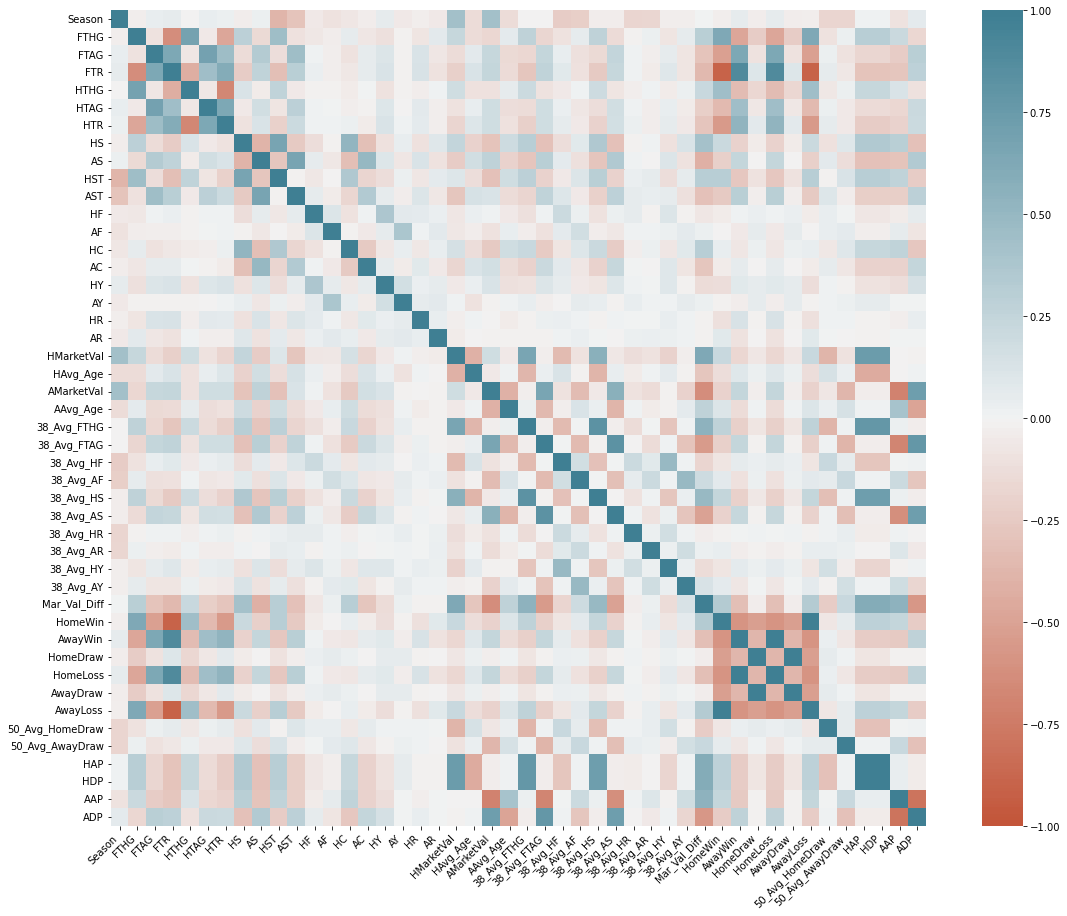

In [ ]:
corr = df_trainingmod.corr()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

In [ ]:
from sklearn.preprocessing import StandardScaler
df_trainingmod.fillna(0, inplace = True) # for empty values in '50_Avg_HomeDraw', works better than mean 
df_trainingmod.columns #can drop match specific columns not in use

Index(['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'HMarketVal', 'HAvg_Age', 'AMarketVal',
       'AAvg_Age', '38_Avg_FTHG', '38_Avg_FTAG', '38_Avg_HF', '38_Avg_AF',
       '38_Avg_HS', '38_Avg_AS', '38_Avg_HR', '38_Avg_AR', '38_Avg_HY',
       '38_Avg_AY', 'Mar_Val_Diff', 'HomeWin', 'AwayWin', 'HomeDraw',
       'HomeLoss', 'AwayDraw', 'AwayLoss', '50_Avg_HomeDraw',
       '50_Avg_AwayDraw', 'HAP', 'HDP', 'AAP', 'ADP'],
      dtype='object')

# 4. Methodology Overview

#Logistic Regression

In [ ]:
feature_cols = ['HAvg_Age','AAvg_Age', '38_Avg_FTHG', '38_Avg_FTAG', '38_Avg_HF', '38_Avg_AF',
                '38_Avg_HS', '38_Avg_AS', '38_Avg_HR', '38_Avg_AR', '38_Avg_HY', '38_Avg_AY',
                'Mar_Val_Diff', '50_Avg_AwayDraw','HDP','ADP','HAP','AAP'] #tested a couple combinations of features this seemed to give the highest result 

X = df_trainingmod[feature_cols] # Features
y = df_trainingmod.FTR # Target variable

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) #split training:testing 75:25

scaler = StandardScaler() #scaling so values in similar range esp market val
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_scaled,y_train)
y_pred=(logreg.predict(X_test_scaled))

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[454,   3,  76],
       [218,   8,  92],
       [192,   3, 189]])

Text(0.5, 257.44, 'Predicted label')

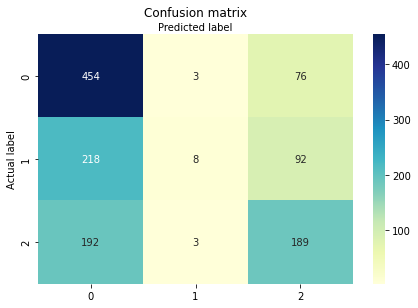

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='micro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='micro'))

Accuracy: 0.5271255060728745
Precision: 0.5271255060728745
Recall: 0.5271255060728745


Accuracy is comparable to 'standard' value of 
53%, clearly model performs poorly when predicting draws. We should try to generate some data more specific to draws (e.g. if two teams have a history of draws against each other specifically not draws in general) Changing the threshold for the prediction classifier may fix this issue, but not sure how to implement this for classification of multiple (non binary) classes.

#Grid Search
Reference to try using:<br>
https://www.kaggle.com/funxexcel/p2-logistic-regression-hyperparameter-tuning
<br>
https://www.youtube.com/watch?v=pooXM9mM7FU

In [ ]:
## not sure if this is correct - accuracy given by optimised logreg parameters is slightly lower than the default
from sklearn.model_selection import GridSearchCV 

param_grid = [{'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['lbfgs','newton-cg','sag','saga'],
              'max_iter' : [100, 1000,2500, 5000]}]

grid_search = GridSearchCV(logreg, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_g_s = grid_search.fit(X_train_scaled,y_train)

print (f'Accuracy - : {best_g_s.score(X_train_scaled,y_train):.3f}')
print (f'Accuracy - : {best_g_s.score(X_test_scaled,y_test):.3f}')

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits
Accuracy - : 0.547
Accuracy - : 0.521


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1680 fits failed out of a total of 3840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: S

In [ ]:
best_g_s.best_estimator_


LogisticRegression(C=0.0018329807108324356)

Cross Validation
- accuracy on training data will be slightly higher than on test data

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10)
result = cross_val_score(logreg, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
print(result)
print(result.mean()) 

[0.51752022 0.52021563 0.51212938 0.55256065 0.52560647 0.57567568
 0.53513514 0.56486486 0.55675676 0.55405405]
0.5414518831499964


Exploring feature importance

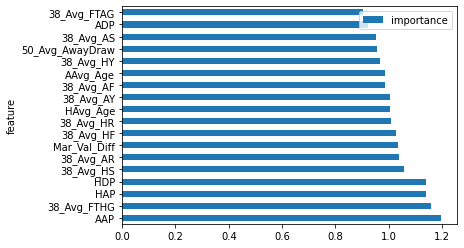

In [ ]:
import math

coef = logreg.coef_[0]

feature_importance = pd.DataFrame(feature_cols, columns = ["feature"])
feature_importance["importance"] = pow(math.e, coef)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

Other Algorithms - K Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 10
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train_scaled,y_train)

y_knn = knn.predict(X_test_scaled)

cnf_matrix = metrics.confusion_matrix(y_test, y_knn)
cnf_matrix

array([[406,  60,  67],
       [190,  53,  75],
       [174,  43, 167]])

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_knn))
print("Precision:",metrics.precision_score(y_test, y_knn, average='micro'))
print("Recall:",metrics.recall_score(y_test, y_knn, average='micro'))

Accuracy: 0.5068825910931174
Precision: 0.5068825910931174
Recall: 0.5068825910931174


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train_scaled,y_train)
y_dtc = dtc.predict(X_test_scaled)

print("Accuracy:",metrics.accuracy_score(y_test, y_dtc))


Accuracy: 0.4064777327935223


Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_gnb = gnb.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, y_gnb))

Accuracy: 0.5036437246963563


Support Vector Machine



In [ ]:
from sklearn import svm
model_svm = svm.SVC(kernel='linear') # Linear Kernel
model_svm.fit(X_train_scaled, y_train)
y_svm = model_svm.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, y_svm))

Accuracy: 0.5198380566801619


(For Report)
Method for plotting rolling average for a specific feature for a specific team, e.g. Yellow Card rolling average for Arsenal

In [ ]:
df = df_trainingmod[['38_Avg_HY','38_Avg_AY']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
Arsenal_YC = df.get_group('Arsenal').to_frame().reset_index().drop(['level_0','level_1'], axis = 1)


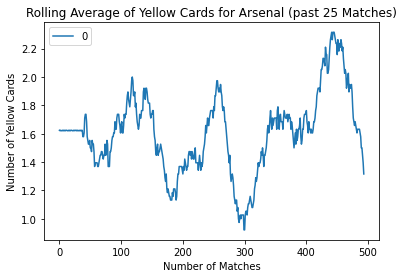

In [ ]:
#Average against num of matches (not accounting for date/seasons not played)
Arsenal_YC.plot()
plt.xlabel('Number of Matches')
plt.ylabel('Number of Yellow Cards')
plt.title('Rolling Average of Yellow Cards for Arsenal (past 25 Matches)')
plt.show()

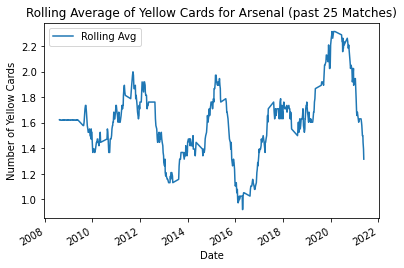

In [ ]:
#Average against date
Dates = df_trainingmod['Date'].to_frame()
Dates = Dates.reset_index()
Dates['Date'] = pd.to_datetime(Dates.Date, dayfirst=True)

df = df_trainingmod[['38_Avg_HY','38_Avg_AY']].stack().groupby(df_trainingmod[['HomeTeam','AwayTeam']].stack().values)
test = df.get_group('Arsenal').to_frame()
test = test.reset_index()

Arsenal_YC_Date= pd.merge(
    test,
    Dates,
    how='left',
    left_on=['level_0'],
    right_on=['index']
).rename(columns={0: 'Rolling Avg'}).drop(['level_0','level_1','index'], axis = 1)

Arsenal_YC_Date.plot('Date', y ='Rolling Avg')
plt.xlabel('Date')
plt.ylabel('Number of Yellow Cards')
plt.title('Rolling Average of Yellow Cards for Arsenal (past 25 Matches)')
plt.show()